In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet18_Weights

dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Dataset downloaded at:", dataset_path)


import zipfile
extract_dir = "brain_tumor_dataset"
if dataset_path.endswith(".zip"):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    extract_dir = dataset_path

train_dir = os.path.join(extract_dir, "Training")
test_dir  = os.path.join(extract_dir, "Testing")

weights = ResNet18_Weights.DEFAULT

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir, transform=transform)

train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_ds, val_ds = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)

class_names = train_data.classes
print("Classes:", class_names)


Dataset downloaded at: /kaggle/input/brain-tumor-mri-dataset
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [5]:
model = BrainTumorCNN().to(device)

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s] 


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

def train_model(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

        train_acc = correct / len(train_loader.dataset)

        model.eval()
        val_correct = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                val_correct += (out.argmax(1) == y).sum().item()
        val_acc = val_correct / len(val_loader.dataset)

        print(f" Epoch {epoch+1:02d}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

In [7]:
train_model(model, train_loader, val_loader, epochs=50)


 Epoch 01: Train Acc = 0.7370, Val Acc = 0.8776
 Epoch 02: Train Acc = 0.8498, Val Acc = 0.9091
 Epoch 03: Train Acc = 0.8625, Val Acc = 0.9143
 Epoch 04: Train Acc = 0.8663, Val Acc = 0.9126
 Epoch 05: Train Acc = 0.8875, Val Acc = 0.9021
 Epoch 06: Train Acc = 0.8881, Val Acc = 0.9108
 Epoch 07: Train Acc = 0.8911, Val Acc = 0.9266
 Epoch 08: Train Acc = 0.8944, Val Acc = 0.9283
 Epoch 09: Train Acc = 0.8979, Val Acc = 0.9266
 Epoch 10: Train Acc = 0.8998, Val Acc = 0.9231
 Epoch 11: Train Acc = 0.9002, Val Acc = 0.9248
 Epoch 12: Train Acc = 0.9064, Val Acc = 0.9126
 Epoch 13: Train Acc = 0.9134, Val Acc = 0.9196
 Epoch 14: Train Acc = 0.9099, Val Acc = 0.9126
 Epoch 15: Train Acc = 0.9095, Val Acc = 0.9213
 Epoch 16: Train Acc = 0.9154, Val Acc = 0.9231
 Epoch 17: Train Acc = 0.9167, Val Acc = 0.9283
 Epoch 18: Train Acc = 0.9169, Val Acc = 0.9283
 Epoch 19: Train Acc = 0.9117, Val Acc = 0.9248
 Epoch 20: Train Acc = 0.9171, Val Acc = 0.9248
 Epoch 21: Train Acc = 0.9183, Val Acc =

In [8]:

torch.save(model.state_dict(), "resnet18_brain_tumor.pth")

print("Model saved.")



Model saved.


In [9]:
model.eval()
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += (out.argmax(1) == y).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9115


In [10]:
def grad_cam(model, input_tensor, target_class):
    model.eval()

    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    hook_f = model.layer4.register_forward_hook(forward_hook)
    hook_b = model.layer4.register_backward_hook(backward_hook)

    output = model(input_tensor.unsqueeze(0))
    model.zero_grad()

    class_score = output[0, target_class]
    class_score.backward()

    hook_f.remove()
    hook_b.remove()

    grads = gradients[0].squeeze()
    acts = activations[0].squeeze()

    weights = grads.mean(dim=[1, 2])
    cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(device)

    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max() if cam.max() != 0 else cam

    return cam

In [11]:
def grad_cam(model, input_tensor, target_class):
    model.eval()

    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    hook_f = model.layer4.register_forward_hook(forward_hook)
    hook_b = model.layer4.register_full_backward_hook(backward_hook)

    output = model(input_tensor.unsqueeze(0))
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    hook_f.remove()
    hook_b.remove()

    if not gradients or not activations:
        raise RuntimeError("Gradients or activations were not captured. Check.")

    grads = gradients[0].squeeze(0)
    acts = activations[0].squeeze(0)
    weights = grads.mean(dim=[1, 2])

    cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(device)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max() if cam.max() != 0 else cam

    return cam


In [12]:
model.eval()
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        correct += (preds.argmax(1) == y).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f" Test Accuracy: {test_acc:.4f}")

 Test Accuracy: 0.9115


In [13]:
import io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()
])

idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}

def predict_uploaded_image(uploaded_file, model, device=device):
    model.eval()
    img = Image.open(io.BytesIO(uploaded_file)).convert("RGB")
    img_t = inference_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, pred = torch.max(outputs, 1)

    class_name = idx_to_class[pred.item()]

    plt.imshow(img)
    plt.title(f" Predicted Tumor Type: {class_name}")
    plt.axis("off")
    plt.show()

uploader = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)

def on_upload_change(change):
    for filename, fileinfo in uploader.value.items():
        print(f" Uploaded: {filename}")
        predict_uploaded_image(fileinfo['content'], model)

uploader.observe(on_upload_change, names='value')
display(uploader)


FileUpload(value=(), accept='.jpg,.jpeg,.png', description='Upload')

In [14]:
%pip install gradio -q

Note: you may need to restart the kernel to use updated packages.


In [15]:
import gradio as gr
import io
from PIL import Image

def predict_image_gradio(image):
    model.eval()
    img = Image.fromarray(image).convert("RGB")
    img_t = inference_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, pred = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[0]

    class_name = idx_to_class[pred.item()]
    confidence = probabilities[pred.item()].item()

    return f"Predicted Tumor Type: {class_name} (Confidence: {confidence:.4f})"

In [16]:
iface = gr.Interface(
    fn=predict_image_gradio,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="Brain Tumor Detection",
    description="Upload an MRI image to predict the tumor type."
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://e37a93c9a9413eda58.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_true.extend(y.tolist())
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.tolist())

Test Accuracy: 0.9115


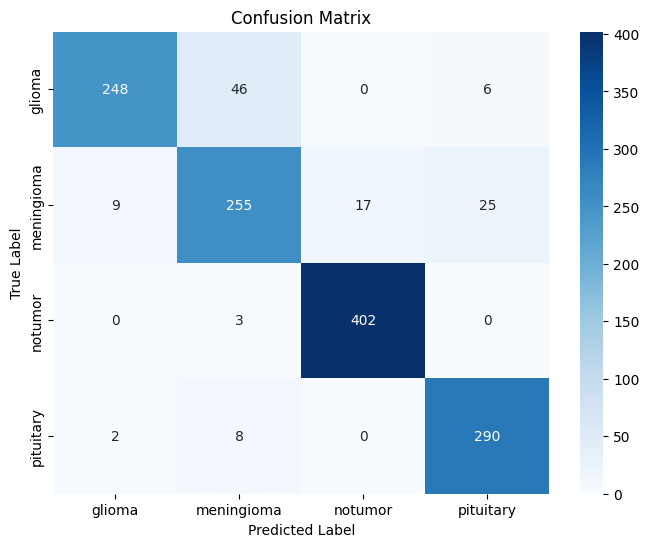

In [18]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [19]:
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.83      0.89       300
  meningioma       0.82      0.83      0.83       306
     notumor       0.96      0.99      0.98       405
   pituitary       0.90      0.97      0.93       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.91      1311
weighted avg       0.91      0.91      0.91      1311



In [23]:
import torch

model = BrainTumorCNN()
torch.save(model.state_dict(), '/kaggle/working/resnet18_brain_tumor.pth')


In [24]:
from IPython.display import FileLink

FileLink('/kaggle/working/resnet18_brain_tumor.pth')  


/kaggle/working/resnet18_brain_tumor.pth

In [26]:
import torch
model = BrainTumorCNN()
model.load_state_dict(torch.load('/kaggle/working/resnet18_brain_tumor.pth'))


<All keys matched successfully>